In [1]:
import pydicom 
import cv2
import random 
import time
import numpy as np 
import pandas as pd
import seaborn as sns
from os import listdir
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.lines as lines


import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

plt.style.use('ggplot')

In [5]:
tf.__version__


'2.4.1'

In [6]:
def rotate_images(image, img_size):
    scale = 1.0
    h = img_size
    w = img_size
    center = (h/2,w/2)
    angle = random.randint(-25,25)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (h,w))
    
    return rotated

def translation (image):
    x = random.randint(-30,30)
    y = random.randint(-30,30)
    rows,cols,z = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv2.warpAffine(image,M,(cols,rows))
    
    return translate

def apply_aug (image, img_size):   
    image = rotate_images(image, img_size)
    image = translation(image)
    
    return image

def oversample_images(X, y, img_size): 
    counter = 0
    new_img = []
    new_label = []
    difference = len(y) - 2*y.sum()
    
    if difference > 0:
        lack_label = 1
    else: 
        lack_label = 0
    
    for i in range(len(y)):    
        if y[i] == lack_label and counter < difference:
            for j in range(round(difference/y.sum())+1):
                image = apply_aug(X[i], img_size)
                counter = counter+1
                new_img.append(image)
                new_label.append(lack_label)     
                
            if i == len(y) and counter < difference:
                n = random.randint(1,len(y)) 
                for j in range(difference - counter):
                    image = apply_aug(X[n], img_size)
                    counter = counter+1
                    new_img.append(image)
                    new_label.append(lack_label)    

    new_img = np.array(new_img)
    new_label = np.array(new_label)

    return new_img, new_label


## Load data

In [11]:
## load labels 
labelname = 'is_icu'
col_uselist = ["to_patient_id", labelname]
label = pd.read_csv('/data/project/iqml/datasets/COVID-19-NY-SBU-CT/COVID-19-NY-SBU-labels.csv', usecols = col_uselist)
label = label.sort_values(by = "to_patient_id", ignore_index = True)

file_list = listdir('/data/project/iqml/datasets/covid_xray_an1')

# drop the subject with weird x-ray image
drop_ID = ['A002304', 'A025840', 'A046441', 'A113004', 'A142433', 'A300871', 'A308607', 'A437957', 'A482389', 'A563909',
           'A587516', 'A590713', 'A642300', 'A672510', 'A673634', 'A702750', 'A735762', 'A740973', 'A750765', 'A771386',
           'A776019', 'A825484', 'A934948']
drop_num = []
for i in range(len(label)):
    if not label['to_patient_id'][i] in file_list:
        drop_num.append(i)
    elif label['to_patient_id'][i] in drop_ID:
        drop_num.append(i)
    
print('drop index:', drop_num)
print('number of droped cases:', len(drop_num))
label = label.drop(drop_num)
label[labelname] = label[labelname].astype(int)
label

drop index: [6, 21, 32, 34, 47, 62, 73, 154, 166, 212, 217, 242, 264, 354, 396, 407, 412, 425, 450, 538, 588, 623, 629, 642, 665, 760, 783, 787, 860, 899, 900, 938, 988, 995, 1007, 1048, 1054, 1143, 1225, 1290, 1327, 1381]
number of droped cases: 42


,to_patient_id,is_icu
0,A000801,1
1,A000936,0
2,A001375,0
3,A001942,0
4,A002052,1
...,...,...
1378,A997729,0
1379,A998063,0
1380,A998860,0
1382,A999046,0


In [13]:
# count the number of true/ false labels
print("True: ",label.iloc[:,1].sum())
print("False: ",len(label.index) - label.iloc[:,1].sum())

True:  253
False:  1089


In [14]:
folder = '/data/project/iqml/datasets/covid_xray_an1/'
img_size = 256
tempdata = []
data = []

for i in label['to_patient_id']:
    
    dcmpath = Path(folder, i, i +'.dcm')
    # load dicom image
    tempdata = pydicom.dcmread(dcmpath)
    tempdata = tempdata.pixel_array
    # rize the image to 256*256
    tempdata = cv2.resize(tempdata, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
    # stack images to 3 channel
    tempdata = np.dstack((tempdata,tempdata,tempdata))
    data.append(tempdata)
    print('load image:', i)


load image: A000801
load image: A000936
load image: A001375
load image: A001942
load image: A002052
load image: A002279
load image: A002471
load image: A003797
load image: A005097
load image: A005163
load image: A008984
load image: A009815
load image: A010092
load image: A012155
load image: A013939
load image: A014950
load image: A016973
load image: A017004
load image: A017227
load image: A018604
load image: A019571
load image: A019709
load image: A020215
load image: A020333
load image: A020519
load image: A021084
load image: A022063
load image: A023023
load image: A023095
load image: A023545
load image: A024671
load image: A027284
load image: A027914
load image: A028914
load image: A030428
load image: A030820
load image: A031437
load image: A032808
load image: A033072
load image: A033798
load image: A034518
load image: A035738
load image: A035785
load image: A036454
load image: A038399
load image: A038686
load image: A038694
load image: A040293
load image: A041535
load image: A041791


load image: A325534
load image: A326684
load image: A326951
load image: A327062
load image: A327819
load image: A329548
load image: A329601
load image: A330101
load image: A330665
load image: A331277
load image: A333626
load image: A333989
load image: A336129
load image: A337808
load image: A337940
load image: A338985
load image: A340910
load image: A340955
load image: A342018
load image: A342350
load image: A343597
load image: A345917
load image: A346398
load image: A347680
load image: A348739
load image: A349057
load image: A349238
load image: A349670
load image: A349708
load image: A349895
load image: A352067
load image: A352169
load image: A353550
load image: A353577
load image: A353725
load image: A354716
load image: A354769
load image: A355016
load image: A355608
load image: A357185
load image: A357192
load image: A357204
load image: A357644
load image: A358050
load image: A358446
load image: A358591
load image: A359779
load image: A360528
load image: A361904
load image: A362446


load image: A632768
load image: A635206
load image: A635855
load image: A635949
load image: A636688
load image: A637185
load image: A638206
load image: A639940
load image: A640895
load image: A641229
load image: A642580
load image: A643574
load image: A643986
load image: A644222
load image: A646350
load image: A647750
load image: A648209
load image: A648481
load image: A649144
load image: A650361
load image: A650418
load image: A651287
load image: A652157
load image: A652246
load image: A652563
load image: A653181
load image: A654278
load image: A654492
load image: A654746
load image: A656088
load image: A656786
load image: A657130
load image: A660468
load image: A661873
load image: A662513
load image: A662554
load image: A662862
load image: A665943
load image: A666238
load image: A667325
load image: A667780
load image: A667803
load image: A669966
load image: A670367
load image: A670597
load image: A670621
load image: A670911
load image: A671620
load image: A674773
load image: A675389


load image: A920434
load image: A920949
load image: A921077
load image: A921742
load image: A922673
load image: A923411
load image: A923527
load image: A925089
load image: A925517
load image: A925839
load image: A926330
load image: A926447
load image: A929180
load image: A929469
load image: A930175
load image: A933548
load image: A934023
load image: A934244
load image: A934713
load image: A936478
load image: A937798
load image: A937900
load image: A939326
load image: A940723
load image: A942131
load image: A942528
load image: A943106
load image: A943462
load image: A943557
load image: A943730
load image: A944071
load image: A944627
load image: A945737
load image: A945931
load image: A946381
load image: A946387
load image: A946930
load image: A947413
load image: A948013
load image: A948145
load image: A948163
load image: A948632
load image: A950017
load image: A951074
load image: A951258
load image: A951393
load image: A951435
load image: A951446
load image: A951599
load image: A952677


(1342, 256, 256, 3)

Shape of the input data:  (1342, 256, 256, 3)
Display Random Input Images


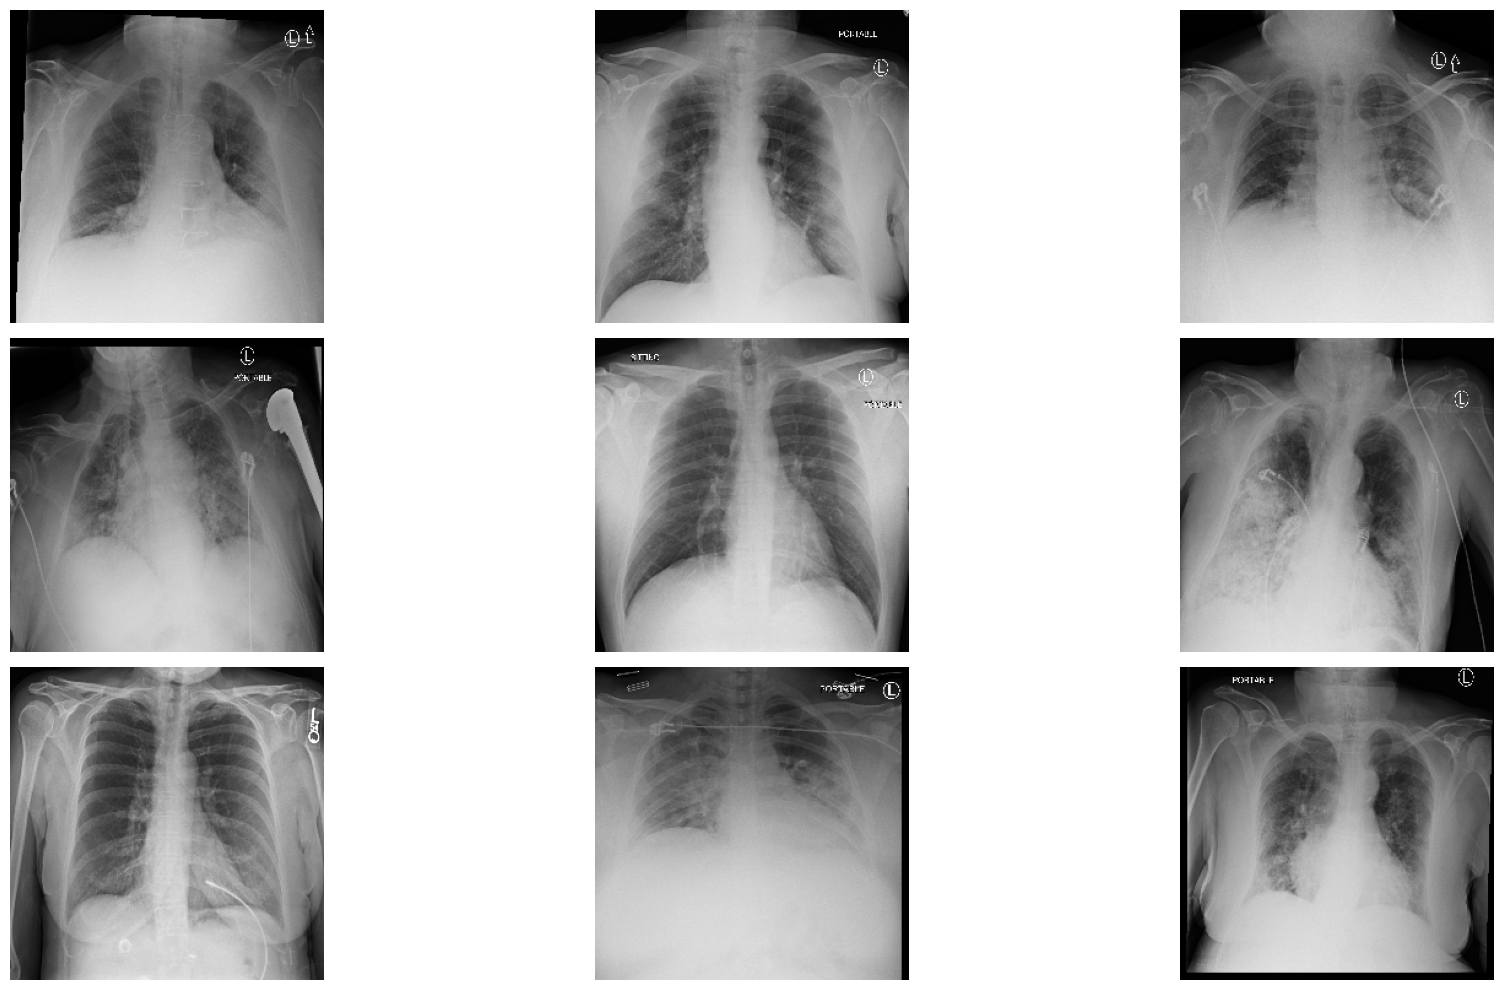

In [17]:
# check images loaded
print('Shape of the input data: ',np.shape(data))
print('Display Random Input Images')
plt.figure(figsize=(20,10))
for i in range(9):
    num = random.randint(0,len(data)-1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(data[num], cv2.COLOR_BGR2GRAY),cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


## Load pre-trained model/ transfer learning

In [40]:
# load model and specify a new input shape
img_size = 256

# Load ResNet50
pre_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
# make conv5 trainable
for layer in pre_model.layers[:143]:
    layer.trainable = False
# check trainable layers
for i, layer in enumerate(pre_model.layers):
    print(i, layer.name, "-", layer.trainable)

# # Load ResNet101
# pre_model = ResNet101(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
# # make conv5 trainable
# for layer in pre_model.layers[:313]:
#     layer.trainable = False   
# # check trainable layers
# for i, layer in enumerate(pre_model.layers):
#     print(i, layer.name, "-", layer.trainable)

# # Load VGG16   
# pre_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
# # make conv5 trainable
# for layer in pre_model.layers[:15]:
#     layer.trainable = False
# # check trainable layers
# for i, layer in enumerate(pre_model.layers):
#     print(i, layer.name, "-", layer.trainable)

model = Sequential()
model.add(pre_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

0 input_4 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

## Random Training/ Testing data split + data augmentation

In [27]:
x = np.array(data)
y = np.array(label[labelname])
# training testing split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)
print('Testing data distribution before data augmentation')
print('x_test', x_test.shape)
print('y_test', y_test.shape)
print("True: ", y_test.sum())
print("False: ",len(y_test) - y_test.sum())

# oversampling
n_img,n_label = oversample_images(x_test, y_test, img_size)
x_test = np.append(x_test,n_img,axis=0)
y_test = np.append(y_test,n_label)
print('Testing data distribution after data augmentation')
print('x_test', x_test.shape)
print('y_test', y_test.shape)
print("True: ", y_test.sum())
print("False: ",len(y_test) - y_test.sum())


Testing data distribution before data augmentation
x_test (269, 256, 256, 3)
y_test (269,)
True:  47
False:  222
Testing data distribution after data augmentation
x_test (444, 256, 256, 3)
y_test (444,)
True:  222
False:  222


Display Random Augmented Images


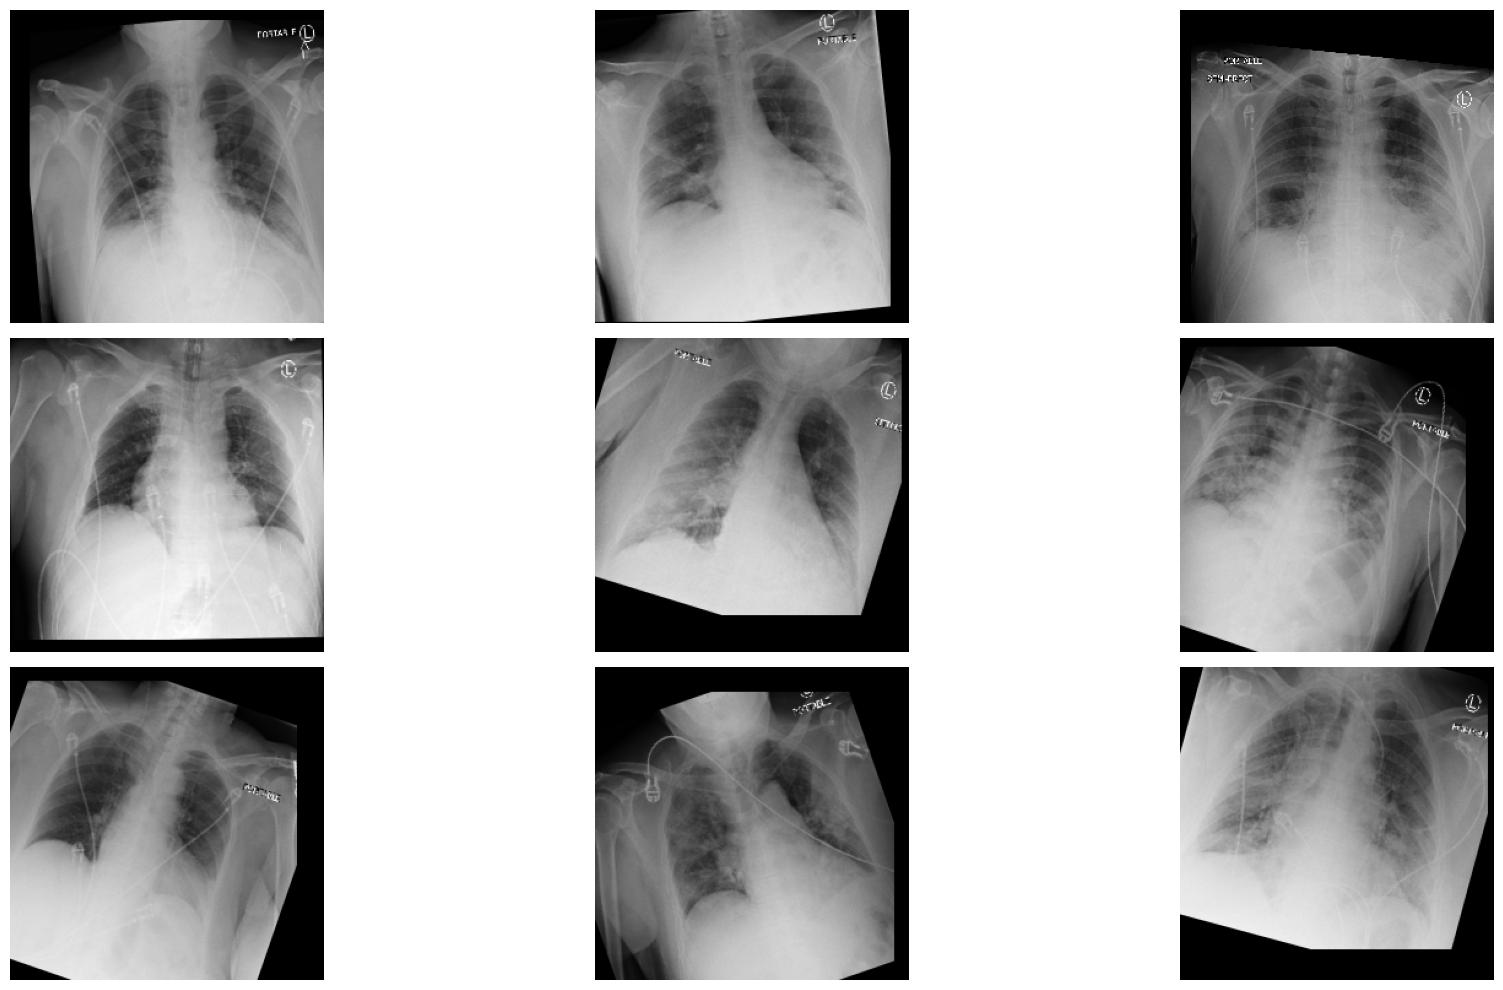

In [28]:
# Plot 9 random images
print('Display Random Augmented Images')
plt.figure(figsize=(20,10))
for i in range(9):
    num = random.randint(0,len(n_img)-1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(n_img[num], cv2.COLOR_BGR2GRAY),cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## K-fold training/ valiadtion split + data augmentation + training 

In [42]:
num_folds = 5
fold_no = 1
acc_per_fold = []
loss_per_fold = []
confusion_list = []
start_time = time.time()

# training validation k fold split
kfold = KFold(n_splits=num_folds, shuffle=True)

for train, val in kfold.split(x_train, y_train):
    
    #  Data augmentation for training data
    n_img,n_label = oversample_images(x_train[train], y_train[train], img_size)
    x_training = np.append(x_train[train],n_img,axis=0)
    y_training = np.append(y_train[train],n_label)
#     print('x_train',x_training.shape)
#     print('y_train',y_training.shape)
#     print("True: ", y_training.sum())
#     print("False: ",len(y_training) - y_training.sum())

    # Data augmentation for validation data
    n_img,n_label = oversample_images(x_train[val], y_train[val], img_size)
    x_val = np.append(x_train[val],n_img,axis=0)
    y_val = np.append(y_train[val],n_label)
#     print('x_val',x_val.shape)
#     print('y_val',y_val.shape)
#     print("True: ", y_val.sum())
#     print("False: ",len(y_val) - y_val.sum())


    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model_lr_reducing = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=1e-8)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
    
    print('------------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(x=x_training, y=y_training, batch_size=16, epochs=50, validation_data=(x_val, y_val), callbacks=[model_lr_reducing])
    
    # evaluate on the testing data subset
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # save the confusion matrix
    y_pred = model.predict(x_test)
    confusion = tf.math.confusion_matrix(
              labels = y_test,      # get truth labels 
              predictions = y_pred>0.5,  # get predicted labels 
              num_classes=2)  
    confusion_list.append(confusion)
    fold_no = fold_no + 1
    
    
print('Average k-fold accuarcy:',np.mean(acc_per_fold))
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
87/87 [==============================] - 9s 72ms/step - loss: 0.3669 - accuracy: 0.8659 - val_loss: 750.0253 - val_accuracy: 0.5014
Epoch 2/50
87/87 [==============================] - 5s 63ms/step - loss: 0.2819 - accuracy: 0.8831 - val_loss: 9.8729 - val_accuracy: 0.5043
Epoch 3/50
87/87 [==============================] - 5s 63ms/step - loss: 0.2938 - accuracy: 0.8680 - val_loss: 0.4143 - val_accuracy: 0.8291
Epoch 4/50
87/87 [==============================] - 5s 63ms/step - loss: 0.2598 - accuracy: 0.8922 - val_loss: 34.4767 - val_accuracy: 0.5043
Epoch 5/50
87/87 [==============================] - 6s 64ms/step - loss: 0.2730 - accuracy: 0.8853 - val_loss: 3.6789 - val_accuracy: 0.5043
Epoch 6/50
87/87 [==============================] - 5s 63ms/step - loss: 0.2533 - accuracy: 0.8947 - val_loss: 0.3668 - val_accuracy: 0.8348
Epoch 7/50
87/87 [==============================

87/87 [==============================] - 5s 63ms/step - loss: 0.0179 - accuracy: 0.9997 - val_loss: 0.5649 - val_accuracy: 0.8547
Score for fold 1: loss of 0.4568788707256317; accuracy of 86.26126050949097%
------------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
86/86 [==============================] - 10s 74ms/step - loss: 0.2474 - accuracy: 0.9029 - val_loss: 0.2010 - val_accuracy: 0.9057
Epoch 2/50
86/86 [==============================] - 5s 64ms/step - loss: 0.1596 - accuracy: 0.9326 - val_loss: 7.6348 - val_accuracy: 0.5121
Epoch 3/50
86/86 [==============================] - 5s 63ms/step - loss: 0.1554 - accuracy: 0.9361 - val_loss: 1.1183 - val_accuracy: 0.6927
Epoch 4/50
86/86 [==============================] - 5s 63ms/step - loss: 0.1310 - accuracy: 0.9359 - val_loss: 0.4373 - val_accuracy: 0.8625

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 5/50
86/86 [===========================

86/86 [==============================] - 5s 64ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1443 - val_accuracy: 0.9461

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.8310547034161573e-07.
Epoch 50/50
86/86 [==============================] - 5s 63ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1451 - val_accuracy: 0.9461
Score for fold 2: loss of 0.6247941255569458; accuracy of 85.13513803482056%
------------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
88/88 [==============================] - 9s 75ms/step - loss: 0.1291 - accuracy: 0.9572 - val_loss: 1.5523 - val_accuracy: 0.7560
Epoch 2/50
88/88 [==============================] - 5s 62ms/step - loss: 0.1382 - accuracy: 0.9548 - val_loss: 0.3780 - val_accuracy: 0.8494
Epoch 3/50
88/88 [==============================] - 5s 62ms/step - loss: 0.0931 - accuracy: 0.9614 - val_loss: 0.2294 - val_accuracy: 0.9157
Epoch 4/50
88/88 [=========================

Epoch 49/50
88/88 [==============================] - 5s 62ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1306 - val_accuracy: 0.9398
Epoch 50/50
88/88 [==============================] - 5s 62ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1327 - val_accuracy: 0.9428

Epoch 00050: ReduceLROnPlateau reducing learning rate to 7.324218813664629e-07.
Score for fold 3: loss of 0.6845299005508423; accuracy of 85.36036014556885%
------------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
87/87 [==============================] - 10s 76ms/step - loss: 0.0821 - accuracy: 0.9727 - val_loss: 0.6646 - val_accuracy: 0.8229
Epoch 2/50
87/87 [==============================] - 5s 63ms/step - loss: 0.0669 - accuracy: 0.9718 - val_loss: 0.2397 - val_accuracy: 0.9057
Epoch 3/50
87/87 [==============================] - 5s 63ms/step - loss: 0.0446 - accuracy: 0.9833 - val_loss: 0.0857 - val_accuracy: 0.9629
Epoch 4/50
87/87 [=============

Epoch 50/50
87/87 [==============================] - 5s 63ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0079 - val_accuracy: 1.0000
Score for fold 4: loss of 0.6861766576766968; accuracy of 86.9369387626648%
------------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
88/88 [==============================] - 10s 74ms/step - loss: 0.0550 - accuracy: 0.9782 - val_loss: 0.4717 - val_accuracy: 0.9006
Epoch 2/50
88/88 [==============================] - 6s 63ms/step - loss: 0.0345 - accuracy: 0.9878 - val_loss: 0.1144 - val_accuracy: 0.9561
Epoch 3/50
88/88 [==============================] - 5s 62ms/step - loss: 0.1078 - accuracy: 0.9682 - val_loss: 0.8241 - val_accuracy: 0.8392
Epoch 4/50
88/88 [==============================] - 5s 63ms/step - loss: 0.0518 - accuracy: 0.9794 - val_loss: 0.1373 - val_accuracy: 0.9532
Epoch 5/50
88/88 [==============================] - 5s 62ms/step - loss: 0.1278 - accuracy: 0.9689 - val_loss: 0.8

88/88 [==============================] - 6s 63ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9883
Epoch 50/50
88/88 [==============================] - 6s 63ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9883

Epoch 00050: ReduceLROnPlateau reducing learning rate to 3.6621094068323146e-07.
Score for fold 5: loss of 0.6596044301986694; accuracy of 85.36036014556885%
Average k-fold accuarcy: 85.8108115196228
--- 1417.4271097183228 seconds ---


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


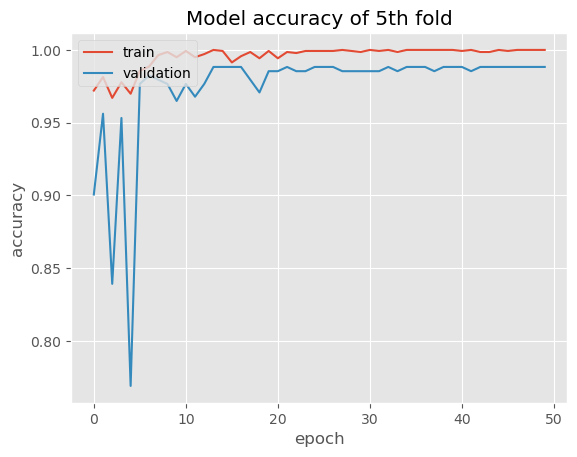

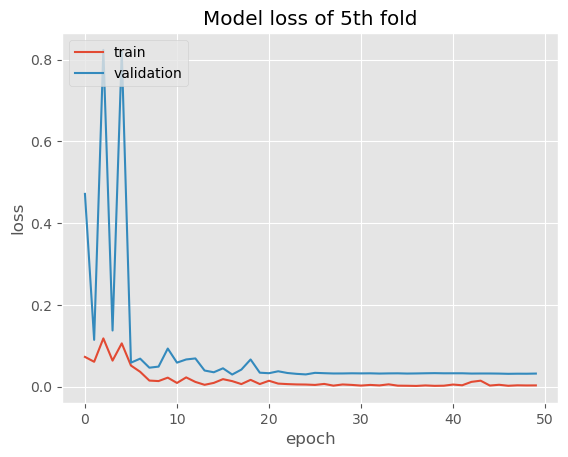

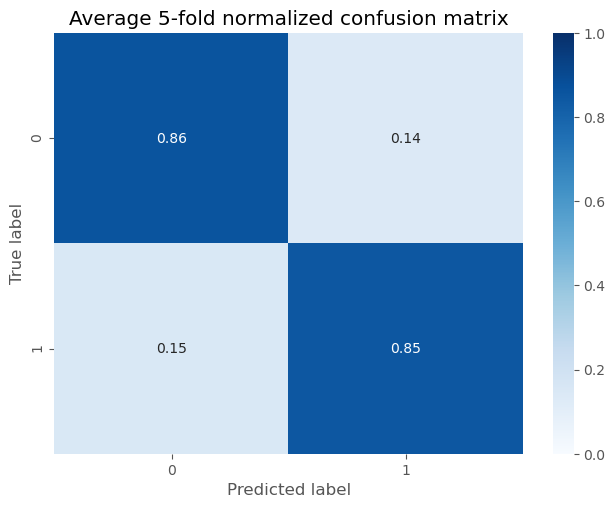

In [44]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy of 5th fold')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss of 5th fold')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# plot k-fold average normalized confusion matrix 
conf_mat_mean = np.mean(confusion_list, axis=0)
conf_mat_norm = np.around(conf_mat_mean.astype('float') / conf_mat_mean.sum(axis=1)[:, np.newaxis], decimals=2)
conf_mat_df = pd.DataFrame(conf_mat_norm, index = [0,1], columns = [0,1])
sns.heatmap(conf_mat_df, annot=True, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.tight_layout()
plt.title('Average 5-fold normalized confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [45]:
model.save('saved_model/resnet50_lr0.003_bs16_ep50,.h5')